# (1) Load library

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize

import time

In [2]:
#Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [3]:
#Neural Network
import tensorflow

In [4]:
print(tensorflow.__version__)

2.5.2


In [5]:
from sklearn.model_selection import train_test_split

# (2) Load Data and Check

In [6]:
#Pandas read_csv 활용
data_path = r'C:/Users/user/Desktop/딥러닝프레임워크_박성호/spam.csv'
data = pd.read_csv(data_path,encoding='latin1')

In [7]:
data.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
#DataFrame 특성을 활용한 변수 추출 및 데이터 변화
data=data[['v1','v2']]
data['v1'].replace(['ham','spam'],[0,1],inplace=True) #ham을 0으로 spam을 1로
data.columns=['Y','des']

In [9]:
data.shape

(5572, 2)

In [10]:
#중복데이터 확인 및 제거
data.drop_duplicates(subset=['des'],inplace=True, keep='first') #ex.3개가 중복되었을 때 첫 번째것만 남기고 나머지 제거(keep='first') #last or False

In [11]:
data.shape

(5169, 2)

# (3) Text 전처리

In [12]:
#(1)
#대문자->소문자
#특수기호 구두점 등 제거
#대문자를 소문자로 바꾼후, 스팸이메일에서 소문자영어나 숫자가 아닌경우 빈 공간으로
normalized_text=[] #전처리된 텍스트

for string in data['des']:
    tokens=re.sub(r"[^a-z0-9]+"," ",string.lower()) #문자와 숫자외 반복되는 것들 제거
    normalized_text.append(tokens)

In [13]:
normalized_text[0]

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat '

In [14]:
#(2)
#단어 토큰화

#normalized_text에서 각각의 이메일을 sentence로 받아서 work_tokenize시키겠다는 것
result=[word_tokenize(sentence) for sentence in normalized_text]

# (4) Word2Vec: Transfer learning = Pre-trained model+fine tuning

In [15]:
googleNews_filepath="C:/Users/user/Desktop/딥러닝프레임워크_박성호/GoogleNews-vectors-negative300.bin.gz"

In [16]:
#LOAD pre-trained key vector
#model을 load한 것이 아니고 Embedding vector만 load
#limit=단어수 조정(빅데이터의 경우)

#start_time=time.time()
PreTrainedKeyvector=KeyedVectors.load_word2vec_format(
    googleNews_filepath, binary=True, limit=5000 #5000개의 단어만 불러올 것
)

#print(f"== {googleNews_filepath} load as word2vec model complete, {time.time()-start_time}")

In [17]:
#Fine tuning 할 새로운 Word2Vec 모델 생성
#PreTrainedKeyvector와 'vector_size'가 같은 word2vec model을 생성
#workers=-1 가용할 수 있는 모든 코어 수

TransferedModel=Word2Vec(size=PreTrainedKeyvector.vector_size,min_count=1, workers=-1)

In [18]:
#단어 생성(build_vocab) by PreTrainedKeyvector word Vocabulary
#TransferedModel.build_vocab input:
#[[]] #list of list

TransferedModel.build_vocab([PreTrainedKeyvector.vocab.keys()])

In [22]:
#주어진 데이터로 새로운 모델의 단어 추가
#update parameter를 True로 설정

TransferedModel.build_vocab(result,update=True)

In [23]:
#단어 수 확인

len(TransferedModel.wv.vocab.keys())

11440

In [24]:
#Pretrained 모델의 학습 파라미터를 기반으로 새로운 모델의 학습 파라미터 초기화
#학습파라미터를 'googleNews_filepath'에 있는 값으로 모두 업데이트해줌
#lockf=0.0 : 보통은 학습 파라미터를 update하지 못하도록 lock이 걸려있음
#lockf=1 : 학습 파라미터를 update하도록 lock 해제

TransferedModel.intersect_word2vec_format(
    googleNews_filepath, binary=True, lockf=1.0
)

In [25]:
#모델 업데이트 - Fine Tuning
#새로운 데이터 기반의 학습
#epochs이 많으면 많을수록 학습을 많이 하는 것

TransferedModel.train(result, total_examples=len(result), epochs=100)

(0, 0)

# (5) Word2Vec으로부터 임베딩 결과 추출

In [26]:
#dictionary 형태로 모든 단어의 임베딩 결과를 추출

embedding_results=dict()

for token in TransferedModel.wv.vocab.keys():
    embedding_results[token] = TransferedModel.wv[token]

In [27]:
TransferedModel.wv

In [28]:
embedding_results.keys()

dict_keys(['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out', 'can', 'It', 'all', 'also', 'two', 'after', 'first', 'He', 'do', 'time', 'than', 'when', 'We', 'over', 'last', 'new', 'other', 'her', 'people', 'into', 'In', 'our', 'there', 'A', 'she', 'could', 'just', 'years', 'some', 'U.S.', 'three', 'million', 'them', 'what', 'But', 'so', 'no', 'like', 'if', 'only', 'percent', 'get', 'did', 'him', 'game', 'back', 'because', 'now', '#.#', 'before', 'company', 'any', 'team', 'against', 'off', 'This', 'most', 'made', 'through', 'make', 'second', 'state', 'well', 'day', 'season', 'says', 'week', 'where', 'while', 'down', 'being', 'government', 'your', '#-#', 'home', 'going', 'my', 'good', 'They

In [29]:
embedding_results['respect']

array([-0.00946045,  0.07226562,  0.33007812,  0.16601562, -0.12695312,
        0.10644531,  0.18457031, -0.31640625,  0.03076172, -0.03955078,
       -0.12158203, -0.0324707 ,  0.10449219,  0.15917969, -0.22265625,
       -0.09472656,  0.13964844,  0.10107422, -0.12109375, -0.02209473,
        0.01031494, -0.14160156, -0.00518799,  0.04882812,  0.24316406,
        0.03930664, -0.08496094, -0.01928711,  0.04980469,  0.14746094,
        0.08154297,  0.11132812, -0.08984375, -0.02746582,  0.11279297,
        0.01660156,  0.171875  ,  0.11767578, -0.012146  ,  0.04614258,
        0.1328125 , -0.18164062,  0.02172852,  0.17480469, -0.18652344,
       -0.29101562, -0.10107422, -0.05078125, -0.09277344, -0.27929688,
       -0.0612793 ,  0.13671875, -0.07861328, -0.19335938, -0.24902344,
        0.16503906, -0.18554688, -0.12792969,  0.01855469, -0.01586914,
       -0.17285156,  0.08447266,  0.15527344, -0.03540039, -0.15234375,
       -0.01757812, -0.24609375,  0.02453613, -0.1640625 ,  0.03

In [30]:
#총 단어 수+1 for unknown words

vocab_size=len(TransferedModel.wv.vocab.keys())+1
vocab_size

11441

In [31]:
#embedding matrix weight_matrix

embedding_matrix=np.zeros((vocab_size, TransferedModel.wv.vector_size))
embedding_matrix.shape

(11441, 300)

In [32]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 정수화

In [33]:
word_to_id = dict()
id_to_word = dict()

all_words=TransferedModel.wv.vocab.keys()

for word in all_words:
    if word not in word_to_id:
        new_id=len(word_to_id)+1
        word_to_id[word]=new_id
        id_to_word[new_id]=word

In [34]:
word_to_id['respect']

1652

In [35]:
id_to_word[1652]

'respect'

In [36]:
word_to_id.items()

dict_items([('</s>', 1), ('in', 2), ('for', 3), ('that', 4), ('is', 5), ('on', 6), ('##', 7), ('The', 8), ('with', 9), ('said', 10), ('was', 11), ('the', 12), ('at', 13), ('not', 14), ('as', 15), ('it', 16), ('be', 17), ('from', 18), ('by', 19), ('are', 20), ('I', 21), ('have', 22), ('he', 23), ('will', 24), ('has', 25), ('####', 26), ('his', 27), ('an', 28), ('this', 29), ('or', 30), ('their', 31), ('who', 32), ('they', 33), ('but', 34), ('$', 35), ('had', 36), ('year', 37), ('were', 38), ('we', 39), ('more', 40), ('###', 41), ('up', 42), ('been', 43), ('you', 44), ('its', 45), ('one', 46), ('about', 47), ('would', 48), ('which', 49), ('out', 50), ('can', 51), ('It', 52), ('all', 53), ('also', 54), ('two', 55), ('after', 56), ('first', 57), ('He', 58), ('do', 59), ('time', 60), ('than', 61), ('when', 62), ('We', 63), ('over', 64), ('last', 65), ('new', 66), ('other', 67), ('her', 68), ('people', 69), ('into', 70), ('In', 71), ('our', 72), ('there', 73), ('A', 74), ('she', 75), ('could

In [37]:
#step vocab, store vectors using the Tokenizer's integer mapping

for word, i in word_to_id.items():
    embedding_matrix[i,:]=embedding_results[word]

In [38]:
embedding_matrix[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [39]:
embedding_matrix[1]

array([ 1.12915039e-03, -8.96453857e-04,  3.18527222e-04,  1.53350830e-03,
        1.10626221e-03, -1.40380859e-03, -3.05175781e-05, -4.19616699e-04,
       -5.76019287e-04,  1.07574463e-03, -1.02233887e-03, -6.17980957e-04,
       -7.55310059e-04,  1.40380859e-03, -1.64031982e-03, -6.33239746e-04,
        1.63269043e-03, -1.00708008e-03, -1.26647949e-03,  6.52313232e-04,
       -4.15802002e-04, -1.07574463e-03,  1.52587891e-03, -2.74658203e-04,
        1.40190125e-04,  1.57165527e-03,  1.35803223e-03, -8.31604004e-04,
       -1.40380859e-03,  1.57928467e-03,  2.53677368e-04, -7.32421875e-04,
       -1.05381012e-04, -1.16729736e-03,  1.57928467e-03,  6.56127930e-04,
       -6.59942627e-04,  2.92062759e-06,  1.12915039e-03,  4.27246094e-04,
       -3.70025635e-04, -1.15203857e-03,  1.26647949e-03, -3.51667404e-06,
        2.65121460e-04, -4.02450562e-04,  1.41143799e-04, -3.36170197e-05,
        7.59124756e-04, -5.18798828e-04, -7.10487366e-05,  6.02722168e-04,
       -5.07354736e-04, -

In [40]:
embedding_matrix[-1]

array([-0.0189209 , -0.11035156, -0.06542969,  0.13183594, -0.00125122,
        0.27734375,  0.05249023,  0.05981445,  0.04760742,  0.16503906,
       -0.28710938, -0.12890625, -0.11816406,  0.02160645, -0.02478027,
        0.22949219,  0.20703125,  0.14257812, -0.006073  , -0.19628906,
       -0.13378906,  0.19238281,  0.02355957, -0.17089844,  0.16015625,
        0.44921875, -0.01660156,  0.00442505,  0.05712891, -0.24609375,
       -0.03833008, -0.16601562,  0.04638672,  0.08349609,  0.02075195,
       -0.12353516,  0.1640625 , -0.125     ,  0.35546875, -0.00946045,
        0.00309753, -0.3046875 ,  0.26757812, -0.06933594, -0.30664062,
       -0.03930664, -0.01611328, -0.0378418 , -0.24121094,  0.01159668,
       -0.25390625, -0.11376953, -0.046875  ,  0.21386719,  0.06933594,
        0.140625  , -0.13476562, -0.16113281,  0.17675781, -0.08398438,
        0.00854492,  0.1640625 ,  0.012146  , -0.22558594,  0.14453125,
       -0.10546875, -0.22949219, -0.13574219, -0.23632812,  0.19

# (6) CNN 기반 데이터 분석

## (1) Text 정수화 

In [41]:
result[0]

['go',
 'until',
 'jurong',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'there',
 'got',
 'amore',
 'wat']

In [42]:
#각 단어를 이미 정해진 인덱스로 변환

encoded_result=[]

for sent in result:
    temp_id=[]
    for word in sent:
        temp_id.append(word_to_id[word])
    encoded_result.append(temp_id)

In [43]:
result[1]

['ok', 'lar', 'joking', 'wif', 'u', 'oni']

In [44]:
encoded_result[1]

[5009, 5010, 5011, 5012, 5013, 5014]

In [45]:
id_to_word[5009]

'ok'

In [46]:
id_to_word[5014]

'oni'

In [47]:
#가장 길이가 긴 email의 길이 계산
#190으로 다른 이메일도 고정 시킬것(나머지를 0으로 채울 것)

max_len=max(len(encoded_email) for encoded_email in encoded_result )
print(max_len)

190


In [48]:
len(encoded_result[0])

20

In [49]:
len(encoded_result[1])

6

## 고정된 길이 padding

In [50]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [51]:
padded_encoded_result=pad_sequences(encoded_result)

In [52]:
padded_encoded_result[0].shape

(190,)

In [53]:
padded_encoded_result[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [54]:
#post: 뒷 부분에 0을 채워넣겠다는 것
#maxlen: 최대 길이

padded_encoded_result=pad_sequences(encoded_result,padding='post',maxlen=5) #뒤에서 다섯개 자른 것

In [55]:
padded_encoded_result[0]

array([5006,   73,  194, 5007, 5008])

In [56]:
padded_encoded_result=pad_sequences(encoded_result,padding='post')

In [57]:
padded_encoded_result[0]

array([ 153,  297, 5001,  284, 4307,  320,   90,    2, 5002, 5003,  268,
        158, 5004, 4212, 5005, 5006,   73,  194, 5007, 5008,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## (2) Train Test 분리

In [58]:
#인덱스를 만드는 것

indices=np.arange(len(padded_encoded_result))
len(indices)

5169

In [59]:
data.shape

(5169, 2)

In [60]:
Y=data['Y']

In [61]:
#shuffle: 뒤죽 박죽 섞는 것

indices_train, indices_test = train_test_split(indices, test_size=0.2, shuffle=True, random_state=0, stratify=Y)

In [72]:
train_X=padded_encoded_result[indices_train]
train_Y=Y.iloc[indices_train]

test_X=padded_encoded_result[indices_test]
test_Y=Y.iloc[indices_test]

## (3) Convolutional Neural Network 구축

In [63]:
train_X[0]

array([4502,   77,  231,  200, 5770,  100, 1937, 5037, 4502,  178,   44,
        302, 5026,   17, 6510,  100,   88,  382,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D#Conv2D
from tensorflow.keras.layers import GlobalMaxPooling1D

In [65]:
#vocab_size: row의 길이
#TransferedModel.wv.vector_size: column의 길이
#원래 weights를 알아서 학습시키는 것이지만 우리는 이미 있는것을 가져다 쓸 것
#trainable=False: embedding_matrix를 train시킬 것이냐 라고 했을 때 안한다는 것

embedding_layer=Embedding(vocab_size, TransferedModel.wv.vector_size, weights=[embedding_matrix], input_length=max_len, trainable=False)

In [66]:
#Architecture 구성
#Conv1D로 하면 input에 맞게끔 너비가 결정, 높이만 결정하면 됨

CNN=Sequential() #순서대로 구성하겠다
CNN.add(embedding_layer)
CNN.add(Conv1D(filters=50, kernel_size=1, activation='relu')) #필터의 개수 50개, kernel_size는 높이(1칸), kernel_size=1이면 190X1짜리가 50개 생김
CNN.add(GlobalMaxPooling1D()) #가장 큰 값을 뽑아서 하나로 요약(50개 만들어짐)
CNN.add(Flatten())
CNN.add(Dense(1, activation='sigmoid')) #fully-connected->Dense, output이 한개
print(CNN.summary())

#3432300짜리 이 파라미터들은 더 이상 학습을 시키지 않는 것

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 190, 300)          3432300   
_________________________________________________________________
conv1d (Conv1D)              (None, 190, 50)           15050     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 3,447,401
Trainable params: 15,101
Non-trainable params: 3,432,300
_________________________________________________________________
None


In [67]:
#학습 요소 구성
#loss: 어떤 손실 함수를 쓸 것인지
#optimizer: adam방식의 경사하강법 사용
#metrics: 이 모델이 잘 구축되었는지 아닌지 볼 지표

CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
#x: Input
#y: Output
#epochs: 반복 횟수
#w를 한 번 업데이트할 때 배치사이즈 만큼의 데이터를 사용

CNN.fit(x=train_X, y=np.array(train_Y), epochs=1, verbose=1, batch_size=32, validation_data=(test_X, np.array(test_Y)))

130/130 [==============================] - 3s 17ms/step - loss: 0.2621 - accuracy: 0.9037 - val_loss: 0.1323 - val_accuracy: 0.9536


In [74]:
history=CNN.fit(x=train_X, y=np.array(train_Y), epochs=100, verbose=1, batch_size=32, validation_data=(test_X, np.array(test_Y)))

Epoch 1/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0966 - accuracy: 0.9756 - val_loss: 0.0774 - val_accuracy: 0.9758
Epoch 2/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0652 - accuracy: 0.9838 - val_loss: 0.0605 - val_accuracy: 0.9778
Epoch 3/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0500 - accuracy: 0.9877 - val_loss: 0.0527 - val_accuracy: 0.9826
Epoch 4/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0402 - accuracy: 0.9901 - val_loss: 0.0491 - val_accuracy: 0.9826
Epoch 5/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0329 - accuracy: 0.9906 - val_loss: 0.0445 - val_accuracy: 0.9845
Epoch 6/100
130/130 [==============================] - 1s 12ms/step - loss: 0.0273 - accuracy: 0.9940 - val_loss: 0.0445 - val_accuracy: 0.9845
Epoch 7/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0223 - accuracy: 0.9964 - val_loss: 0.0431 - val_accuracy:

Epoch 57/100
130/130 [==============================] - 2s 12ms/step - loss: 1.1081e-04 - accuracy: 1.0000 - val_loss: 0.0580 - val_accuracy: 0.9855
Epoch 58/100
130/130 [==============================] - 1s 11ms/step - loss: 1.0202e-04 - accuracy: 1.0000 - val_loss: 0.0564 - val_accuracy: 0.9855
Epoch 59/100
130/130 [==============================] - 2s 12ms/step - loss: 9.5477e-05 - accuracy: 1.0000 - val_loss: 0.0587 - val_accuracy: 0.9855
Epoch 60/100
130/130 [==============================] - 1s 11ms/step - loss: 8.9784e-05 - accuracy: 1.0000 - val_loss: 0.0590 - val_accuracy: 0.9855
Epoch 61/100
130/130 [==============================] - 2s 12ms/step - loss: 8.2230e-05 - accuracy: 1.0000 - val_loss: 0.0584 - val_accuracy: 0.9855
Epoch 62/100
130/130 [==============================] - 1s 11ms/step - loss: 7.6844e-05 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9865
Epoch 63/100
130/130 [==============================] - 2s 12ms/step - loss: 6.9967e-05 - accuracy: 1.0000

findfont: Font family ['MaruBuri-SemiBold'] not found. Falling back to DejaVu Sans.
findfont: Font family ['MaruBuri-SemiBold'] not found. Falling back to DejaVu Sans.


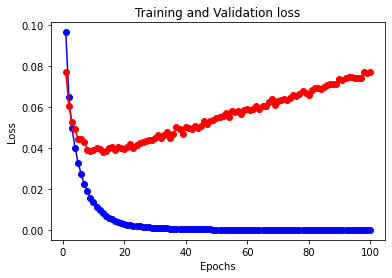

In [75]:
loss_train=history.history['loss']
loss_val=history.history['val_loss']

epochs=range(1,101)
plt.plot(epochs, loss_train, 'b-o',label='Training loss')
plt.plot(epochs, loss_val, 'r-o',label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend
plt.show()

In [77]:
#무작위로 노드들 몇개를 선택해서 학습을 안시키겠다는 것
from tensorflow.keras.layers import Dropout

#Architecture 구성
#Conv1D로 하면 input에 맞게끔 너비가 결정, 높이만 결정하면 됨

CNN2=Sequential() #순서대로 구성하겠다
CNN2.add(embedding_layer)
CNN2.add(Conv1D(filters=50, kernel_size=1, activation='relu')) #필터의 개수 50개, kernel_size는 높이(1칸), kernel_size=1이면 190X1짜리가 50개 생김
CNN2.add(GlobalMaxPooling1D()) #가장 큰 값을 뽑아서 하나로 요약(50개 만들어짐)
CNN2.add(Flatten())
CNN2.add(Dropout(rate=0.3)) #10개면 3개를 drop
CNN2.add(Dense(1, activation='sigmoid')) #fully-connected->Dense, output이 한개
print(CNN.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 190, 300)          3432300   
_________________________________________________________________
conv1d (Conv1D)              (None, 190, 50)           15050     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 3,447,401
Trainable params: 15,101
Non-trainable params: 3,432,300
_________________________________________________________________
None


In [78]:
#학습 요소 구성
#loss: 어떤 손실 함수를 쓸 것인지
#optimizer: adam방식의 경사하강법 사용
#metrics: 이 모델이 잘 구축되었는지 아닌지 볼 지표

CNN2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
history2=CNN2.fit(x=train_X, y=np.array(train_Y), epochs=100, verbose=1, batch_size=32, validation_data=(test_X, np.array(test_Y)))

Epoch 1/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0204 - accuracy: 0.9940 - val_loss: 0.0389 - val_accuracy: 0.9903
Epoch 2/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0180 - accuracy: 0.9952 - val_loss: 0.0396 - val_accuracy: 0.9865
Epoch 3/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0140 - accuracy: 0.9966 - val_loss: 0.0390 - val_accuracy: 0.9865
Epoch 4/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0167 - accuracy: 0.9956 - val_loss: 0.0375 - val_accuracy: 0.9884
Epoch 5/100
130/130 [==============================] - 2s 13ms/step - loss: 0.0148 - accuracy: 0.9954 - val_loss: 0.0386 - val_accuracy: 0.9884
Epoch 6/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0133 - accuracy: 0.9973 - val_loss: 0.0392 - val_accuracy: 0.9894
Epoch 7/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0150 - accuracy: 0.9969 - val_loss: 0.0408 - val_accuracy:

130/130 [==============================] - 2s 13ms/step - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.0552 - val_accuracy: 0.9865
Epoch 58/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0558 - val_accuracy: 0.9884
Epoch 59/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0551 - val_accuracy: 0.9874
Epoch 60/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0043 - accuracy: 0.9983 - val_loss: 0.0593 - val_accuracy: 0.9865
Epoch 61/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0087 - accuracy: 0.9978 - val_loss: 0.0581 - val_accuracy: 0.9865
Epoch 62/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.0595 - val_accuracy: 0.9884
Epoch 63/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0036 - accuracy: 0.9995 - val_loss: 0.0614 - val_accuracy: 0.986

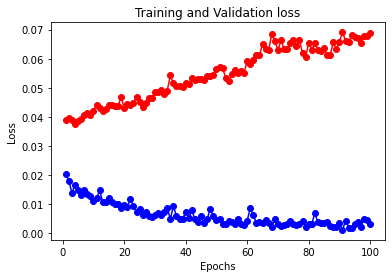

In [81]:
loss_train=history2.history['loss']
loss_val=history2.history['val_loss']

epochs=range(1,101)
plt.plot(epochs, loss_train, 'b-o',label='Training loss')
plt.plot(epochs, loss_val, 'r-o',label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend
plt.show()

In [82]:
#Architecture 구성
#Conv1D로 하면 input에 맞게끔 너비가 결정, 높이만 결정하면 됨

CNN3=Sequential() #순서대로 구성하겠다
CNN3.add(embedding_layer)
CNN3.add(Conv1D(filters=10, kernel_size=1, activation='relu')) 
CNN3.add(GlobalMaxPooling1D()) #가장 큰 값을 뽑아서 하나로 요약(50개 만들어짐)
CNN3.add(Flatten())
CNN3.add(Dropout(rate=0.3)) #10개면 3개를 drop
CNN3.add(Dense(1, activation='sigmoid')) #fully-connected->Dense, output이 한개

print(CNN.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 190, 300)          3432300   
_________________________________________________________________
conv1d (Conv1D)              (None, 190, 50)           15050     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 3,447,401
Trainable params: 15,101
Non-trainable params: 3,432,300
_________________________________________________________________
None


In [83]:
#학습 요소 구성
#loss: 어떤 손실 함수를 쓸 것인지
#optimizer: adam방식의 경사하강법 사용
#metrics: 이 모델이 잘 구축되었는지 아닌지 볼 지표

CNN3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
history3=CNN3.fit(x=train_X, y=np.array(train_Y), epochs=100, verbose=1, batch_size=32, validation_data=(test_X, np.array(test_Y)))

Epoch 1/100
130/130 [==============================] - 2s 9ms/step - loss: 0.4054 - accuracy: 0.8631 - val_loss: 0.2862 - val_accuracy: 0.8733
Epoch 2/100
130/130 [==============================] - 1s 10ms/step - loss: 0.2619 - accuracy: 0.9011 - val_loss: 0.1730 - val_accuracy: 0.9439
Epoch 3/100
130/130 [==============================] - 1s 9ms/step - loss: 0.1870 - accuracy: 0.9374 - val_loss: 0.1246 - val_accuracy: 0.9652
Epoch 4/100
130/130 [==============================] - 1s 8ms/step - loss: 0.1572 - accuracy: 0.9439 - val_loss: 0.1068 - val_accuracy: 0.9691
Epoch 5/100
130/130 [==============================] - 1s 9ms/step - loss: 0.1469 - accuracy: 0.9524 - val_loss: 0.0944 - val_accuracy: 0.9710
Epoch 6/100
130/130 [==============================] - 1s 8ms/step - loss: 0.1390 - accuracy: 0.9548 - val_loss: 0.0855 - val_accuracy: 0.9749
Epoch 7/100
130/130 [==============================] - 1s 8ms/step - loss: 0.1365 - accuracy: 0.9550 - val_loss: 0.0844 - val_accuracy: 0.973

Epoch 58/100
130/130 [==============================] - 1s 7ms/step - loss: 0.0471 - accuracy: 0.9852 - val_loss: 0.0547 - val_accuracy: 0.9845
Epoch 59/100
130/130 [==============================] - 1s 7ms/step - loss: 0.0484 - accuracy: 0.9843 - val_loss: 0.0569 - val_accuracy: 0.9865
Epoch 60/100
130/130 [==============================] - 1s 7ms/step - loss: 0.0524 - accuracy: 0.9828 - val_loss: 0.0555 - val_accuracy: 0.9855
Epoch 61/100
130/130 [==============================] - 1s 8ms/step - loss: 0.0495 - accuracy: 0.9845 - val_loss: 0.0565 - val_accuracy: 0.9855
Epoch 62/100
130/130 [==============================] - 1s 8ms/step - loss: 0.0487 - accuracy: 0.9831 - val_loss: 0.0561 - val_accuracy: 0.9855
Epoch 63/100
130/130 [==============================] - 1s 7ms/step - loss: 0.0467 - accuracy: 0.9838 - val_loss: 0.0573 - val_accuracy: 0.9865
Epoch 64/100
130/130 [==============================] - 1s 7ms/step - loss: 0.0491 - accuracy: 0.9831 - val_loss: 0.0562 - val_accuracy:

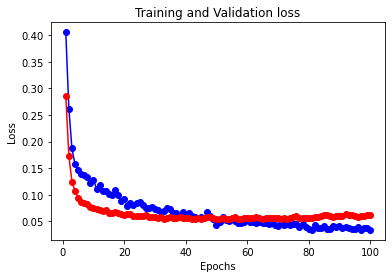

In [85]:
loss_train=history3.history['loss']
loss_val=history3.history['val_loss']

epochs=range(1,101)
plt.plot(epochs, loss_train, 'b-o',label='Training loss')
plt.plot(epochs, loss_val, 'r-o',label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend
plt.show()

# 정확도 파악 - 다양한 지표를 통해서 

In [95]:
pred_Y=CNN3.predict(test_X)

In [96]:
pred_Y

array([[2.0453334e-04],
       [2.4038553e-04],
       [9.9980152e-01],
       ...,
       [1.0886490e-03],
       [9.9664974e-01],
       [3.1549633e-02]], dtype=float32)

In [97]:
pred_Y_class=pred_Y.copy()

pred_Y_class[pred_Y>=0.5]=1
pred_Y_class[pred_Y<0.5]=0

In [98]:
pred_Y_class

array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [94]:
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score

In [99]:
print(accuracy_score(pred_Y_class,test_Y))

0.9845261121856866


In [101]:
print(confusion_matrix(pred_Y_class,test_Y))

[[898  11]
 [  5 120]]


In [102]:
print(recall_score(pred_Y_class,test_Y)) #spam을 spam으로 예측했느냐

0.96


# GPU VS CPU 연산비교 

In [103]:
import tensorflow as tf

print('Available GPUs: ',tf.test.is_gpu_available())
print(tf.config.experimental.list_logical_devices('GPU'))
print(tf.config.experimental.list_logical_devices('CPU'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Available GPUs:  False
[]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]


In [104]:
#Architecture 구성
#Conv1D로 하면 input에 맞게끔 너비가 결정, 높이만 결정하면 됨

CNN=Sequential() #순서대로 구성하겠다
CNN.add(embedding_layer)
CNN.add(Conv1D(filters=50, kernel_size=1, activation='relu')) #필터의 개수 50개, kernel_size는 높이(1칸), kernel_size=1이면 190X1짜리가 50개 생김
CNN.add(GlobalMaxPooling1D()) #가장 큰 값을 뽑아서 하나로 요약(50개 만들어짐)
CNN.add(Flatten())
CNN.add(Dropout(rate=0.3))
CNN.add(Dense(1, activation='sigmoid')) #fully-connected->Dense, output이 한개
print(CNN.summary())

#3432300짜리 이 파라미터들은 더 이상 학습을 시키지 않는 것

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 190, 300)          3432300   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 190, 50)           15050     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 3,447,401
Trainable params: 15,101
Non-trainable params: 3,432,300
_______________________________________

In [105]:
#학습 요소 구성
#loss: 어떤 손실 함수를 쓸 것인지
#optimizer: adam방식의 경사하강법 사용
#metrics: 이 모델이 잘 구축되었는지 아닌지 볼 지표

CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])w

In [106]:
with tf.device('/device:CPU:0'):
    history=CNN.fit(x=train_X, y=np.array(train_Y), epochs=10, verbose=1, batch_size=32, validation_data=(test_X, np.array(test_Y)))

#GPU가 확실히 더 빠름

Epoch 1/10
130/130 [==============================] - 2s 14ms/step - loss: 0.3060 - accuracy: 0.8759 - val_loss: 0.1627 - val_accuracy: 0.9449
Epoch 2/10
130/130 [==============================] - 2s 12ms/step - loss: 0.1359 - accuracy: 0.9591 - val_loss: 0.0892 - val_accuracy: 0.9720
Epoch 3/10
130/130 [==============================] - 2s 13ms/step - loss: 0.0972 - accuracy: 0.9698 - val_loss: 0.0705 - val_accuracy: 0.9768
Epoch 4/10
130/130 [==============================] - 2s 13ms/step - loss: 0.0765 - accuracy: 0.9775 - val_loss: 0.0607 - val_accuracy: 0.9778
Epoch 5/10
130/130 [==============================] - 2s 13ms/step - loss: 0.0707 - accuracy: 0.9775 - val_loss: 0.0572 - val_accuracy: 0.9807
Epoch 6/10
130/130 [==============================] - 2s 13ms/step - loss: 0.0615 - accuracy: 0.9819 - val_loss: 0.0533 - val_accuracy: 0.9826
Epoch 7/10
130/130 [==============================] - 2s 12ms/step - loss: 0.0554 - accuracy: 0.9855 - val_loss: 0.0497 - val_accuracy: 0.9816